In [1]:
from pathlib import Path

import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay
from matplotlib.pyplot import subplots


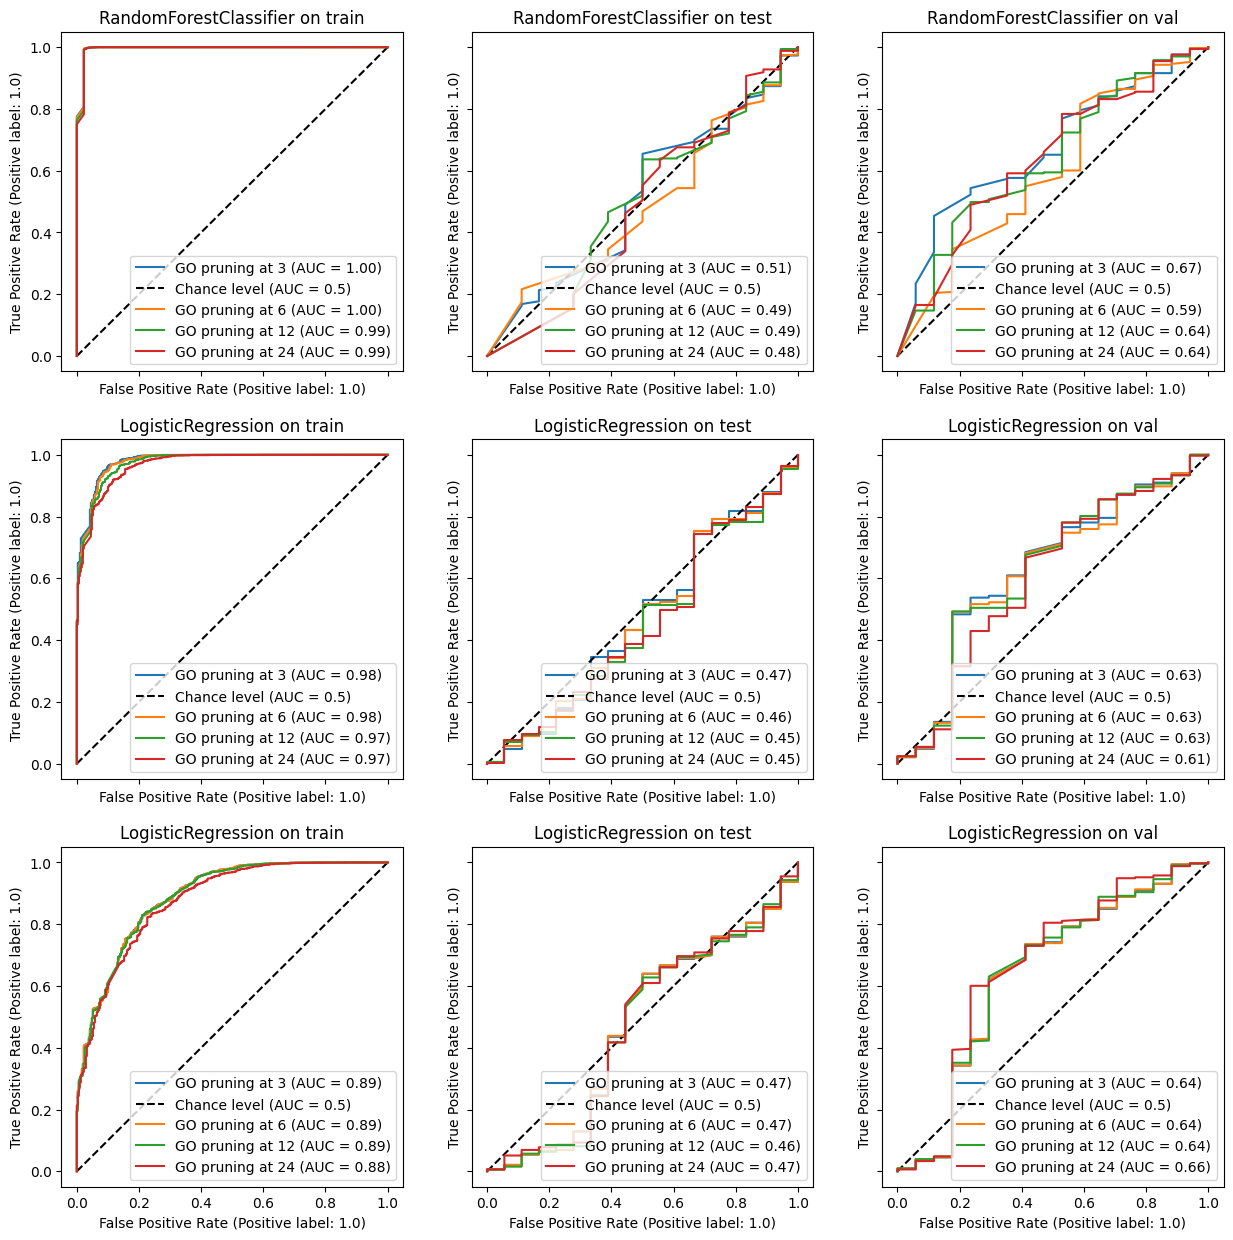

In [18]:
models = [RandomForestClassifier, LogisticRegression, lambda: LogisticRegression(penalty='l1', solver='liblinear')]
sets = ['train', 'test', 'val']

fig, ax = subplots(nrows=len(models), ncols=len(sets), sharex=True, sharey=True, squeeze=False, figsize=(15,15))

first = True
for data, pruning in ((torch.load(Path(f'../data/cpg0016_v3_{pruning}.pt')), pruning) for pruning in [3,6,12,24]):
    y = (data.y+1)/2
    for row, model_generator in enumerate(models):
        model = model_generator()
        model.fit(data.x[data.train_mask, :], y[data.train_mask,0])

        for col, set_prefix in enumerate(sets):
            mask = data[f'{set_prefix}_mask']
            RocCurveDisplay.from_estimator(model, data.x[mask, :], y[mask, 0], name=f'GO pruning at {pruning}', plot_chance_level=first, ax=ax[row, col])
            if first:
                ax[row, col].set_title(f'{model.__class__.__name__} on {set_prefix}')

    first = False